# Straggler experiments (figure 9)

Use bagging to train an ensemble of models for Clipper to demonstrate the effects of stragglers

In [1]:
import pandas as pd
import numpy as np
import sklearn.linear_model
%matplotlib inline
import matplotlib.pyplot as plt
import os
import sys
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')


def load_digits(digits_location, digits_filename = "train-mnist-dense-with-labels.data"):
    digits_path = os.path.join(digits_location, digits_filename)
    print "Source file:", digits_path
    df = pd.read_csv(digits_path, sep=",", header=None)
    data = df.values
    print "Number of image files:", len(data)
    y = data[:,0]
    X = data[:,1:]
    return (X, y)

def to_image(x):
    return np.reshape(x,[28,28])

def display_digit(x):
    plt.imshow(to_image(x), interpolation='none')

def display_random_digits(X, y):
    ind = np.random.permutation(len(X))
    plt.figure()
    for i in range(0, 16):
        plt.subplot(4,4,i+1)
        display_digit(X[ind[i],:])
        plt.draw()
        # Display the plot

        
def normalize_digits(X):
    mu = np.mean(X,0)
    sigma = np.var(X,0)
    Z = (X - mu) / np.array([np.sqrt(z) if z > 0 else 1. for z in sigma])
    return Z 

def fourier_project(X, nfeatures = 4096, scale = 1.e-4):
    (n,d) = X.shape
    W = np.random.normal(scale = scale, size = [d, nfeatures])
    phase = np.random.uniform( size = [1, nfeatures]) * 2.0 * np.pi
    randomFeatures = np.cos(X.dot(W) + phase)
    return randomFeatures

def filter_two_class(X, y, digitA = 3, digitB = 9):
    indexes = (y == (digitA + 1)) | (y == (digitB + 1))
    binary_labels = (y == (digitA + 1)) * 1.
    return (X[indexes], binary_labels[indexes])
    
#     return (yInd, yBinary[yInd])


def train_test_split(y, propTrain = 0.75):
    ind = np.random.permutation(len(y))
    split_ind = ind[0.75 * len(y)]
    train_ind = ind[:split_ind]
    test_ind = ind[split_ind:]
    print "Train size: ", len(train_ind)
    print "Train true: ", np.mean(y[train_ind] == 1.0)
    print "Test size:  ", len(test_ind)
    print "Test true:  ", np.mean(y[test_ind] == 1.0)
    return (train_ind, test_ind)


In [2]:
# Load data
train_x, train_y = load_digits(os.path.expanduser("/Users/crankshaw/model-serving/data/mnist_data"))
train_x = normalize_digits(train_x)

test_x, test_y = load_digits(os.path.expanduser("/Users/crankshaw/model-serving/data/mnist_data"), "test-mnist-dense-with-labels.data")
test_x = normalize_digits(test_x)

# Train decision tree classifiers
models = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=20, max_samples=0.1, n_jobs=-1)
models.fit(train_x, train_y)

# Look at baseline score
print "Ensemble score: %f" % models.score(test_x, test_y)
for m in models.estimators_:
    print m.score(test_x, test_y - 1)

Source file: /Users/crankshaw/model-serving/data/mnist_data/train-mnist-dense-with-labels.data
Number of image files: 60000
Source file: /Users/crankshaw/model-serving/data/mnist_data/test-mnist-dense-with-labels.data
Number of image files: 10000
Ensemble score: 0.921600
0.7125
0.7272
0.7324
0.7639
0.6662
0.5567
0.5832
0.7253
0.7346
0.7804
0.6162
0.6649
0.4876
0.7609
0.7771
0.7331
0.7796
0.6734
0.7468
0.7106


In [3]:
# Run straggler experiment

def vote(estimators, x, y):
    votes = np.zeros(len(estimators[0].classes_))
    for m in estimators:
        y_pred = m.predict(x)
        votes[y_pred] += 1
    y_hat = np.argmax(votes) + 1
    return int(y_hat == y)
    
scores = []    
for num_estimators in range(1,21):
    num_correct = 0
    for i in range(len(test_y)):
        num_correct += vote(models.estimators_[:num_estimators], test_x[i].reshape(1,-1), test_y[i])
    score = float(num_correct)/float(len(test_y))
    print score
    scores.append(score)
scores.reverse()

0.7125
0.7706
0.8232
0.8615
0.8684
0.8717
0.878
0.8886
0.8955
0.9017
0.9022
0.9056
0.905
0.9099
0.9126
0.9142
0.9155
0.9172
0.9209
0.9216


[0.7125, 0.7706, 0.8232, 0.8615, 0.8684, 0.8717, 0.878, 0.8886, 0.8955, 0.9017, 0.9022, 0.9056, 0.905, 0.9099, 0.9126, 0.9142, 0.9155, 0.9172, 0.9209, 0.9216]


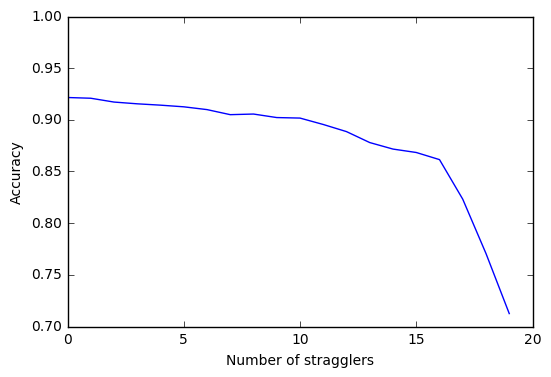

In [6]:
print scores
fig, ax = plt.subplots()
ax.plot(range(20), scores)
ax.set_xlabel("Number of stragglers")
ax.set_ylabel("Accuracy")
ax.set_ylim((ax.get_ylim()[0],1.0))
plt.show()
